In [1]:
from neuron import h
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#First compile our modfiles.
if os.system('nrnivmodl modfiles/') == 0:
    print("Compilation Succeeded.")
else:
    print("Compilation Failed.")

Compilation Succeeded.


In [2]:
h.load_file('stdrun.hoc')

#Define simumulation parameters.
SIMRUNTIME = 1500
DELAY      = 400
INJTIME    = 500
I_INJ      = 0.2

h.tstop    = SIMRUNTIME
h.v_init   = -75

SEGREGATED = True

#Now set up vectors to record the membrane potential and the time.
potential = h.Vector()
time      = h.Vector()

In [3]:
#Plot membrane potential of tonic cell.
def plot_membrane():
    plt.close()
    plt.figure(figsize = (20,5))
    plt.plot(time, potential)
    plt.xlabel('Time')
    plt.ylabel('Membrane Potential')
    plt.show()




In [4]:

soma = h.Section(name = 'soma')

iclamp = h.IClamp(soma(0.5))
iclamp.dur   = INJTIME
iclamp.amp   = I_INJ
iclamp.delay = DELAY

#Record time and membrane potential for tonic cell.
time.record(h._ref_t) 
potential.record(soma(0.5)._ref_v)


#We will make a super simple one compartement tonic spiking cell.
soma.nseg = 1 
soma.L    = 25
soma.diam = 24.75

#First insert the passive module.
soma.insert('leakCA3')

#Insert the calculated values from passive properties
soma.glbar_leakCA3 = 1.53*3e-5
soma.el_leakCA3 = -75
soma.cm = 1

#Insert h channel (This is appart of the passive module, but it interferes with calcuating passive properties).
soma.insert('hdCA3')

#Now insert the spiking module.
soma.insert('natCA3')
soma.insert('kdrCA3')

if not SEGREGATED:
    soma.mseg_natCA3 = -200
    soma.nseg_kdrCA3 = -200
    soma.lseg_hdCA3 = 200
    


In [5]:
def run_tonic_model(gna, gkdr, gh, gleak):

    soma.gbar_natCA3   = gna
    soma.gbar_kdrCA3   = gkdr
    soma.ghdbar_hdCA3  = gh
    soma.glbar_leakCA3 = gleak
    
    h.run()


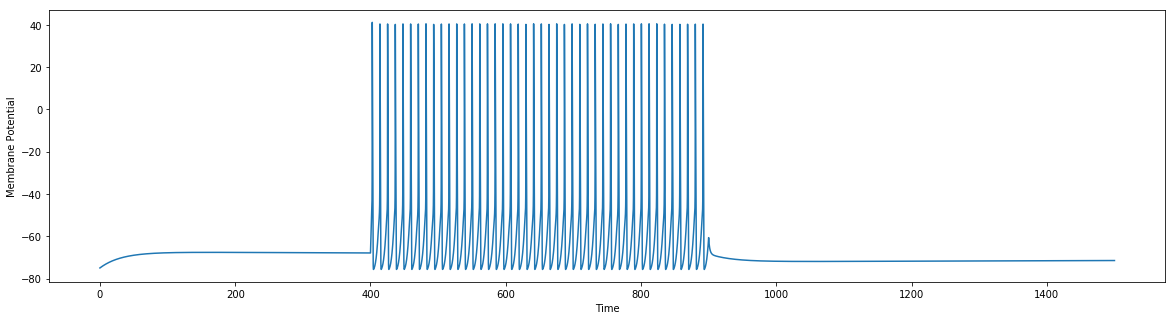

In [6]:
run_tonic_model(0.065, 0.065, 1.0e-5, 2.857142857142857e-05)

plot_membrane()


In [7]:
from scipy import stats as spstats
from scipy.signal import find_peaks
def Stats(trace):
    """
    Calculates summary statistics
    results = model(params)
    """

    
    resting = np.mean(trace[4500:10500])
    Max  = max(trace)
    Min = min(trace)
        
    peak_times = np.asarray(find_peaks(trace,height=0)[0])
    
    firstPeak = float('inf')
    avg_int = float('inf')
    
    
    if len(peak_times) > 0:
        firstPeak = time[peak_times[0]]

        #Average interval.
        avg_int = 0
        for i in range(1,len(peak_times)):
            avg_int += time[peak_times[i]] - time[peak_times[i - 1]]

        avg_int /= len(peak_times)
    
    
    allStats = np.concatenate((resting,Max,Min,firstPeak,avg_int),axis=None)
   
    return np.array(allStats)

In [8]:
print(Stats(potential.as_numpy()))

[-67.66370996  41.18800865 -75.70922209 402.65        11.11420455]


In [9]:
def simulation_wrapper(params):
    arr = np.asarray(params)
    run_tonic_model(arr[0],arr[1],arr[2],arr[3])
    return Stats(potential.as_numpy())

In [10]:
def plot_wrapper(params):
    arr = np.asarray(params)
    run_tonic_model(arr[0],arr[1],arr[2],arr[3])
    plot_membrane()

In [11]:
Lows = torch.tensor([0.001,0.001,1e-6,1e-6], dtype=float)
Highs = torch.tensor([0.1,0.1,1e-4,1e-3], dtype=float)

prior = utils.BoxUniform(low=Lows,high=Highs)

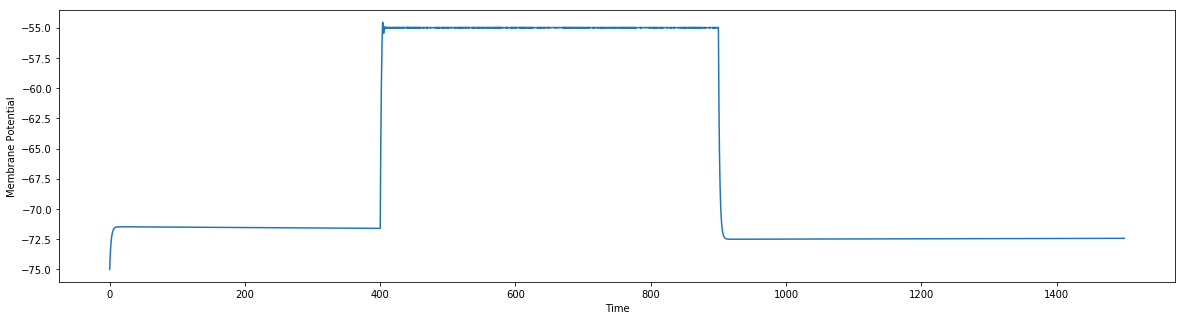

In [12]:
simulator, prior = prepare_for_sbi(simulation_wrapper, prior)
density_estimator = posterior_nn(model='maf',hidden_features=12)
inference = SNPE(prior=prior,density_estimator=density_estimator,show_progress_bars=True)

plot_wrapper(prior.sample())

In [13]:
posteriors = []
proposal = prior
num_rounds=2
x_o = torch.from_numpy(np.asarray([-67.6637099,41.18800865,-75.70922209,402.65,11.11420455])) #Need to find this set of summary stats
torch.manual_seed(0)

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal,num_simulations=1000)
    
     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(show_train_summary=True,use_combined_loss=True)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/mizzou/tools/utils/conda/envs/py36/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Neural network successfully converged after 568 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 568
        Best validation performance: 27.5304
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
Neural network successfully converged after 57 epochs.

        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: 3.8242
        -------------------------
        


In [14]:
observation_summary_statistics = x_o
samples = posterior.sample((10000,), x=x_o)#,sample_with_mcmc=True)

log_probability = posterior.log_prob(samples, x = x_o)#,norm_posterior=False)
predicted_post_index = np.argmin(log_probability)
predicted_post = samples[predicted_post_index]

print("predicted post is: ",predicted_post)
#print("correlation coefficient between true and predicted = %f" %np.corrcoef(model(true_params),model(predicted_post))[0][1])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

predicted post is:  tensor([6.6139e-02, 7.3474e-02, 3.4703e-05, 4.6440e-05])


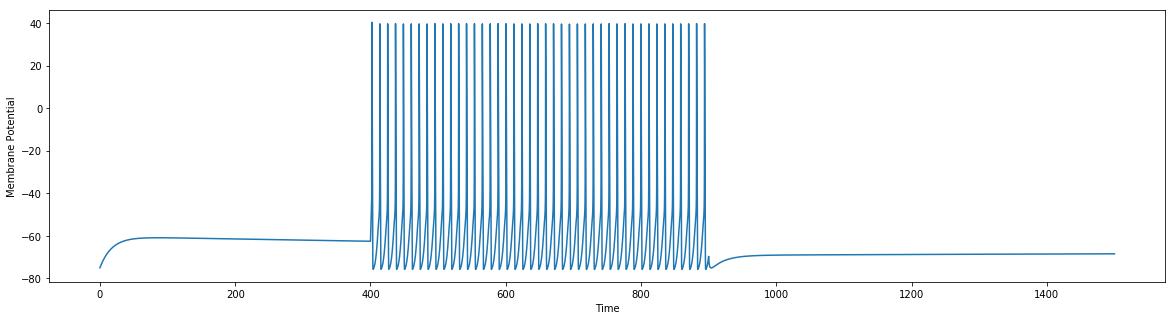

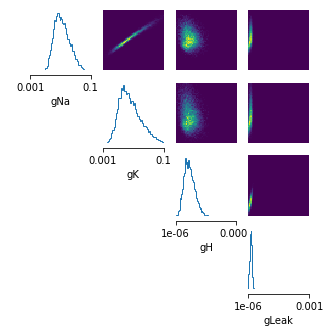

In [15]:
plot_wrapper(predicted_post)

labels_params = ['gNa', 'gK','gH', 'gLeak']
fig, axes = utils.pairplot(samples,
                           limits=[[Lows[0],Highs[0]],[Lows[1],Highs[1]],[Lows[2],Highs[2]], [Lows[3],Highs[3]]],
                           ticks=[[Lows[0],Highs[0]],[Lows[1],Highs[1]],[Lows[2],Highs[2]], [Lows[3],Highs[3]]],
                           fig_size=(5,5),
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');
